In [1]:
import optuna
import pandas as pd
import numpy as np
optuna.logging.set_verbosity(optuna.logging.WARNING)
import plotly
import plotly.io as pio
pio.renderers.default = "iframe"

**Loading the days dataset**

In [2]:
df = pd.read_csv('../house-hold-energy-data/days.csv')
df.head()

,TIMESTAMP,USAGE,COST
0,2016-10-22,4.52,0.60
1,2016-10-23,23.32,4.36
2,2016-10-24,7.16,1.20
3,2016-10-25,8.68,1.60
4,2016-10-26,5.04,0.84


*Convert the datetime column*

In [3]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df.set_index('TIMESTAMP', inplace=True)
df.head()

,USAGE,COST
TIMESTAMP,,
2016-10-22,4.52,0.60
2016-10-23,23.32,4.36
2016-10-24,7.16,1.20
2016-10-25,8.68,1.60
2016-10-26,5.04,0.84


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 733 entries, 2016-10-22 to 2018-10-24
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USAGE   733 non-null    float64
 1   COST    733 non-null    float64
dtypes: float64(2)
memory usage: 17.2 KB


### Pre-processing 

Pre-processing steps:
1. Get the training, testing, and validation set sizes
    - The size of those sets includes the 30 days worth of lag

**Generating 30 days worth of usage lag**

In [5]:
def generated_lagged_features(df, feature, max_lag):
    for t in range(1, max_lag + 1):
        df[feature + "_lag" + str(t)] = df[feature].shift(t)

In [6]:
generated_lagged_features(df, 'USAGE', 30)
df

,USAGE,COST,USAGE_lag1,USAGE_lag2,USAGE_lag3,USAGE_lag4,USAGE_lag5,USAGE_lag6,USAGE_lag7,USAGE_lag8,...,USAGE_lag21,USAGE_lag22,USAGE_lag23,USAGE_lag24,USAGE_lag25,USAGE_lag26,USAGE_lag27,USAGE_lag28,USAGE_lag29,USAGE_lag30
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2016-10-22,4.52,0.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-23,23.32,4.36,4.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-24,7.16,1.20,23.32,4.52,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-25,8.68,1.60,7.16,23.32,4.52,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-26,5.04,0.84,8.68,7.16,23.32,4.52,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-20,8.00,1.68,7.76,4.76,5.88,7.72,6.64,8.40,8.84,8.28,...,8.48,9.52,7.68,6.16,10.80,5.68,9.08,5.88,7.12,7.68
2018-10-21,1.12,0.16,8.00,7.76,4.76,5.88,7.72,6.64,8.40,8.84,...,10.44,8.48,9.52,7.68,6.16,10.80,5.68,9.08,5.88,7.12
2018-10-22,0.64,0.04,1.12,8.00,7.76,4.76,5.88,7.72,6.64,8.40,...,12.84,10.44,8.48,9.52,7.68,6.16,10.80,5.68,9.08,5.88


In [7]:
df.dropna(inplace=True)
df

,USAGE,COST,USAGE_lag1,USAGE_lag2,USAGE_lag3,USAGE_lag4,USAGE_lag5,USAGE_lag6,USAGE_lag7,USAGE_lag8,...,USAGE_lag21,USAGE_lag22,USAGE_lag23,USAGE_lag24,USAGE_lag25,USAGE_lag26,USAGE_lag27,USAGE_lag28,USAGE_lag29,USAGE_lag30
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2016-11-21,9.44,1.76,7.00,10.36,17.68,19.04,10.00,5.64,8.44,16.40,...,8.84,7.44,10.64,4.64,5.32,5.04,8.68,7.16,23.32,4.52
2016-11-22,16.28,2.84,9.44,7.00,10.36,17.68,19.04,10.00,5.64,8.44,...,11.44,8.84,7.44,10.64,4.64,5.32,5.04,8.68,7.16,23.32
2016-11-23,19.20,3.48,16.28,9.44,7.00,10.36,17.68,19.04,10.00,5.64,...,18.20,11.44,8.84,7.44,10.64,4.64,5.32,5.04,8.68,7.16
2016-11-24,22.20,4.12,19.20,16.28,9.44,7.00,10.36,17.68,19.04,10.00,...,14.16,18.20,11.44,8.84,7.44,10.64,4.64,5.32,5.04,8.68
2016-11-25,13.80,2.56,22.20,19.20,16.28,9.44,7.00,10.36,17.68,19.04,...,8.28,14.16,18.20,11.44,8.84,7.44,10.64,4.64,5.32,5.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-20,8.00,1.68,7.76,4.76,5.88,7.72,6.64,8.40,8.84,8.28,...,8.48,9.52,7.68,6.16,10.80,5.68,9.08,5.88,7.12,7.68
2018-10-21,1.12,0.16,8.00,7.76,4.76,5.88,7.72,6.64,8.40,8.84,...,10.44,8.48,9.52,7.68,6.16,10.80,5.68,9.08,5.88,7.12
2018-10-22,0.64,0.04,1.12,8.00,7.76,4.76,5.88,7.72,6.64,8.40,...,12.84,10.44,8.48,9.52,7.68,6.16,10.80,5.68,9.08,5.88


**Getting the training, testing, and validation sizes**

In [8]:
# 80% Training, 10% testing, 10% validation
train_size = int(df.shape[0] * 0.8)
test_size = int(df.shape[0] * 0.1)
valid_size = df.shape[0] - train_size - test_size

print(f'Training Size: {train_size}, Testing Size: {test_size}, Validation Size: {valid_size}')

df_train = df[:train_size]
df_test = df[train_size:train_size + test_size]
df_valid = df[train_size + test_size:]

Training Size: 562, Testing Size: 70, Validation Size: 71


In [9]:
### Creating datasets

explanatory_cols_mask = np.char.startswith(df.columns.to_numpy().astype(str), 'USAGE') # Mask where 'USAGE' is in the column name
explanatory_cols = df.columns[explanatory_cols_mask]
response_col = 'COST'

X_train = df_train[explanatory_cols]
y_train = df_train[response_col].values.reshape(-1,1)
X_test = df_test[explanatory_cols]
y_test = df_test[response_col].values.reshape(-1,1)
X_val = df_valid[explanatory_cols]
y_val = df_valid[response_col].values.reshape(-1,1)

**Scaling the data**

Next, I will scale the data by first creating a scaler object on the original 'USAGE' column and then apply the object to it's lagged features. This way, we stay consistent with the scaling of features

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [11]:
### Scalers
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaler.fit(X_train['USAGE'].values.reshape(-1,1))
y_scaler.fit(y_train)

def scale_features(col):
    return X_scaler.transform(col.values.reshape(-1,1)).flatten()

def scale_predictor(col):
    return y_scaler.transform(col)

In [12]:
def scale_columns(col):
    return X_scaler.transform(col.values.reshape(-1,1)).flatten()

In [13]:
X_train_scaled = X_train.apply(scale_features, axis=0)
X_test_scaled = X_test.apply(scale_features, axis=0)
X_val_scaled = X_val.apply(scale_features, axis=0)

In [14]:
X_train_scaled.head()

,USAGE,USAGE_lag1,USAGE_lag2,USAGE_lag3,USAGE_lag4,USAGE_lag5,USAGE_lag6,USAGE_lag7,USAGE_lag8,USAGE_lag9,...,USAGE_lag21,USAGE_lag22,USAGE_lag23,USAGE_lag24,USAGE_lag25,USAGE_lag26,USAGE_lag27,USAGE_lag28,USAGE_lag29,USAGE_lag30
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2016-11-21,-0.392984,-0.714548,-0.271738,0.692955,0.872188,-0.319182,-0.893781,-0.524772,0.524266,-0.282281,...,-0.472057,-0.656561,-0.234837,-1.025570,-0.935953,-0.972854,-0.493143,-0.693462,1.436244,-1.041384
2016-11-22,0.508451,-0.392984,-0.714548,-0.271738,0.692955,0.872188,-0.319182,-0.893781,-0.524772,0.524266,...,-0.129406,-0.472057,-0.656561,-0.234837,-1.025570,-0.935953,-0.972854,-0.493143,-0.693462,1.436244
2016-11-23,0.893274,0.508451,-0.392984,-0.714548,-0.271738,0.692955,0.872188,-0.319182,-0.893781,-0.524772,...,0.761486,-0.129406,-0.472057,-0.656561,-0.234837,-1.025570,-0.935953,-0.972854,-0.493143,-0.693462
2016-11-24,1.288641,0.893274,0.508451,-0.392984,-0.714548,-0.271738,0.692955,0.872188,-0.319182,-0.893781,...,0.229059,0.761486,-0.129406,-0.472057,-0.656561,-0.234837,-1.025570,-0.935953,-0.972854,-0.493143
2016-11-25,0.181615,1.288641,0.893274,0.508451,-0.392984,-0.714548,-0.271738,0.692955,0.872188,-0.319182,...,-0.545859,0.229059,0.761486,-0.129406,-0.472057,-0.656561,-0.234837,-1.025570,-0.935953,-0.972854


In [15]:
y_train_scaled = scale_predictor(y_train)
y_test_scaled = scale_predictor(y_test)
y_val_scaled = scale_predictor(y_val)

In [16]:
y_train_scaled[:5]

array([[-0.48065018],
       [ 0.22813367],
       [ 0.64815373],
       [ 1.06817379],
       [ 0.0443749 ]])

## Baseline Logistic Regression

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [18]:
reg = LinearRegression()
reg.fit(X_train_scaled, y_train_scaled)

y_pred = reg.predict(X_test_scaled)
y_pred_inverse = y_scaler.inverse_transform(y_pred)

rmse = np.sqrt(mean_squared_error(y_pred_inverse, y_test))
print(f"RMSE: {rmse}")

RMSE: 0.25827218556108217


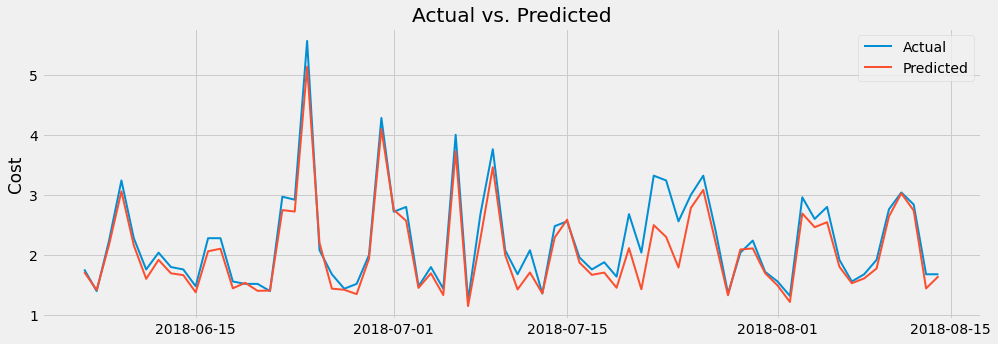

In [19]:
plt.figure(figsize=(15,5))
linewidth = 2
plt.plot(df_test[response_col].index, y_test, label='Actual', linewidth=linewidth)
plt.plot(df_test[response_col].index, y_pred_inverse, label='Predicted', linewidth=linewidth)
plt.title('Actual vs. Predicted')
plt.ylabel('Cost')
plt.legend();

In [20]:
(y_pred_inverse - y_test).sum()

-12.034533135961947

### Optimizing Linear Regression with Optuna

*Baseline*

In [21]:
from sklearn.model_selection import cross_val_score

def objective():
    
    reg = LinearRegression()
    return cross_val_score(reg, X_train_scaled, y_train_scaled, n_jobs=-1, cv=3, scoring='neg_root_mean_squared_error').mean()

print('RMSE: {}'.format(objective()*-1))

RMSE: 0.18607516679932304


In [22]:
from sklearn.ensemble import ExtraTreesRegressor

In [23]:
def objective():
    
    reg = ExtraTreesRegressor()
    return cross_val_score(reg, X_train_scaled, y_train_scaled, n_jobs=-1, cv=3, scoring='neg_root_mean_squared_error').mean()

print('RMSE: {}'.format(objective()*-1))

RMSE: 0.19501748911749697


In [24]:
ExtraTreesRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [25]:
# param_grid = {
#     'n_estimators': [int(x) for x in np.arange(start = 100, stop = 2100, step = 100)],
#     'criterion': ['mse', 'mae'],
#     'max_depth': [2,8,16,32,50],
#     'min_sample_split': [2,4,6],
#     'min_sample_leaf': [1,2],
#     #'oob_score': [True, False],
#     'max_features': ['auto','sqrt','log2'],    
#     'bootstrap': [True, False],
#     'warm_start': [True, False],
# }

def objective(trial):
    
    #n_estimators = trail.suggest_int('n_estimators', 100, 2000 )
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 2, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 2)
    }
    
    reg = ExtraTreesRegressor()
    reg.set_params(**param_grid)
    return cross_val_score(reg, X_train_scaled, y_train_scaled, n_jobs=-1, cv=3, scoring='neg_root_mean_squared_error').mean() * -1

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('RMSE: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

RMSE: 0.18602149227502895
Best hyperparameters: {'n_estimators': 157, 'max_depth': 7, 'min_samples_split': 10, 'bootstrap': False, 'min_samples_leaf': 1}


**Looking at the results**

In [26]:
optuna.visualization.plot_optimization_history(study)

In [27]:
optuna.visualization.plot_slice(study)

Combining together

In [28]:
reg = ExtraTreesRegressor()
reg.set_params(**trial.params)
reg.fit(X_train_scaled, y_train_scaled.ravel())

y_pred = reg.predict(X_test_scaled)
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1,1))

rmse = np.sqrt(mean_squared_error(y_pred_inverse, y_test))
print(f"RMSE: {rmse}")

RMSE: 0.2709020684776325


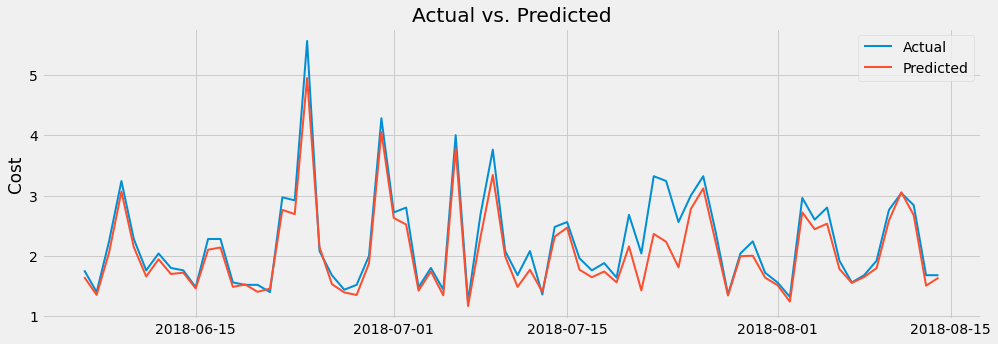

In [29]:
plt.figure(figsize=(15,5))
linewidth = 2
plt.plot(df_test[response_col].index, y_test, label='Actual', linewidth=linewidth)
plt.plot(df_test[response_col].index, y_pred_inverse, label='Predicted', linewidth=linewidth)
plt.title('Actual vs. Predicted')
plt.ylabel('Cost')
plt.legend();

In [30]:
(y_pred_inverse - y_test).sum()

-12.597565333725619

### Optimizing XGBoost

In [31]:
import xgboost as xgb
xgb.set_config(verbosity=0)

In [40]:
def objective(trial):

    param = {
        "silent": 1,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "lambda": trial.suggest_float("lambda", 0.0, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 30),
        "n_estimators" : trial.suggest_int("n_estimators", 300, 2000)
    }
        
    model = xgb.XGBRegressor(verbose=0, **param)
    model.fit(X_train_scaled, 
              y_train_scaled,
              eval_set=[(X_val_scaled, y_val_scaled)], 
              early_stopping_rounds=10,
              eval_metric='rmse',
              verbose=0)
    y_pred = model.predict(X_test)
    
    y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1,1))
    rmse = np.sqrt(mean_squared_error(y_pred_inverse, y_test))
    return rmse

In [41]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

trial = study.best_trial
print('RMSE: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

RMSE: 3.921831151695584
Best hyperparameters: {'booster': 'dart', 'learning_rate': 0.37656164041135254, 'lambda': 0.8404659354719586, 'max_depth': 24, 'n_estimators': 970}


In [42]:
reg = xgb.XGBRegressor(verbose=0, **trial.params, eval_metric='reg:squarederror')
reg.fit(X_train_scaled, 
        y_train_scaled,
        eval_set=[(X_val_scaled, y_val_scaled)], 
        early_stopping_rounds=5,
        eval_metric='rmse',
        verbose=0)

y_pred = reg.predict(X_test_scaled)
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1,1))

rmse = np.sqrt(mean_squared_error(y_pred_inverse, y_test))
print(f"RMSE: {rmse}")

RMSE: 0.25052678676639956


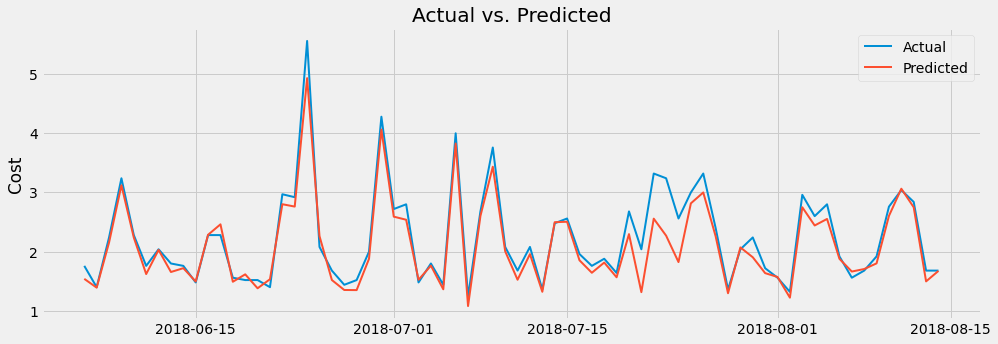

In [43]:
plt.figure(figsize=(15,5))
linewidth = 2
plt.plot(df_test[response_col].index, y_test, label='Actual', linewidth=linewidth)
plt.plot(df_test[response_col].index, y_pred_inverse, label='Predicted', linewidth=linewidth)
plt.title('Actual vs. Predicted')
plt.ylabel('Cost')
plt.legend();

In [44]:
(y_pred_inverse - y_test).sum()

-9.885002765655518

In [45]:
optuna.visualization.plot_slice(study)

In [46]:
optuna.visualization.plot_optimization_history(study)